In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import ast
from ast import literal_eval

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression



from datetime import datetime

# ORGANISATION
- classification - alicia / maria 
- temporal evolution - anissa 
- majoritiy representation - virginie
- climate speaking proprotion - virginie 
- sentiment analysis - alicia / maria 
- readme data,set  - virginie
- readme methodes - alicia / maria 
- data story (site web) - anissa

- [doing] CLASSIFICATION - Based on the evolution of the profile of a person talking about climate in the media, can we predict what characteristics will a climate-involved person have in the future ? 
 
 - [doing] TEMPORAL EVOLUTION - Is there any temporal evolution in the mediatic coverage of the climate crisis ? If so, does it correlate with specific events ? 
 
 - [doing] MAJORITY REPRESENTATION - Who are the top 10 people that talks the most about climate change over the year ? Does it show an evolution in the general opinions made publicly avaiblable by mainstream media ? What is the current typical profile of a person talking about climate in the media ? Is it the same for other topic ? (Comparaison entre les caractéristiques de personnes les plus représentées dans le QuoteBank vs celles qui parlent du climat) (comparaison des nationalités avec une carte du monde) 
 
 - [x] CLIMATE SPEAKING PROPORTION - Are some communities excluded from the mediatic discussion surround climate change ? (Comparer la proportion de chacun des communautés dans QB en général avec la propotion des communautés dans les phrases qui parlent du climat) - plot climate vs non climate 
 
 - [x] NLP TOPIC CLASSIFICATION - What is the most represented climate crisis-related topic along the years ? Does it show an evolution in the general opinions made publicly avaiblable by mainstream media ? (Trouver les mots reliés au climat les plus représentés dans les quotes chaque années) 

- [x] SENTIMENT ANALYSIS - Vander Analysis among people that talks about climate

# A RUN POUR AVOIR SUBDATA (Year-month)

In [2]:
dico_clean={} 
length = 0
for date in [2020, 2019, 2018, 2017, 2016, 2015]:
    dico_clean[date] = pd.read_csv(f'data/clean_quotes-{date}.bz2', compression='bz2')
    length += len(dico_clean[date]) #The length is used here to obtain the total number of quotes.

In [3]:
subdata=pd.DataFrame()
for years, quotes in dico_clean.items() : 
    subdata = pd.concat([subdata, quotes])

In [4]:
subdata.date.map(lambda y : datetime.strptime(y, '%Y-%m-%d %H:%M:%S'))
subdata.sort_values(by='date', inplace=True)
subdata['date'] = pd.to_datetime(subdata['date']).dt.strftime('%Y-%m')

# I- CLASSIFICATION - ALICIA ET MARIA

In [ ]:
#Run virginie

## *Methods*

In [76]:
def compute_confusion_matrix(true_label, prediction_proba, decision_threshold=0.5): 
    
    predict_label = (prediction_proba[:,1]>decision_threshold).astype(int)   
                                                                                                                       
    TP = np.sum(np.logical_and(predict_label==1, true_label==1))
    TN = np.sum(np.logical_and(predict_label==0, true_label==0))
    FP = np.sum(np.logical_and(predict_label==1, true_label==0))
    FN = np.sum(np.logical_and(predict_label==0, true_label==1))
    
    confusion_matrix = np.asarray([[TP, FP],
                                    [FN, TN]])
    return confusion_matrix

def plot_confusion_matrix(confusion_matrix):
    [[TP, FP],[FN, TN]] = confusion_matrix
    label = np.asarray([['TP {}'.format(TP), 'FP {}'.format(FP)],
                        ['FN {}'.format(FN), 'TN {}'.format(TN)]])
    
    df_cm = pd.DataFrame(confusion_matrix, index=['Yes', 'No'], columns=['Positive', 'Negative']) 
    
    return sns.heatmap(df_cm, cmap='YlOrRd', annot=label, annot_kws={"size": 16}, cbar=False, fmt='')

def compute_all_score(confusion_matrix, t=0.5):
    [[TP, FP],[FN, TN]] = confusion_matrix.astype(float)
    
    accuracy =  (TP+TN)/np.sum(confusion_matrix)
    
    precision_positive = TP/(TP+FP) if (TP+FP) !=0 else np.nan
    precision_negative = TN/(TN+FN) if (TN+FN) !=0 else np.nan
    
    recall_positive = TP/(TP+FN) if (TP+FN) !=0 else np.nan
    recall_negative = TN/(TN+FP) if (TN+FP) !=0 else np.nan

    F1_score_positive = 2 *(precision_positive*recall_positive)/(precision_positive+recall_positive) if (precision_positive+recall_positive) !=0 else np.nan
    F1_score_negative = 2 *(precision_negative*recall_negative)/(precision_negative+recall_negative) if (precision_negative+recall_negative) !=0 else np.nan

    return [t, accuracy, precision_positive, recall_positive, F1_score_positive, precision_negative, recall_negative, F1_score_negative]

In [41]:
def accuracy (matrix_confusion) : 
    
    [t, accuracy, precision_positive, recall_positive, F1_score_positive, \
    precision_negative, recall_negative, F1_score_negative] = compute_all_score(matrix_confusion)
    print("The accuracy of this model is {0:1.3f}".format(accuracy))
    print("For the positive case, the precision is {0:1.3f}, the recall is {1:1.3f} and the F1 score is {2:1.3f}"\
      .format(precision_positive, recall_positive, F1_score_positive))
    print("For the negative case, the precision is {0:1.3f}, the recall is {1:1.3f} and the F1 score is {2:1.3f}"\
      .format(precision_negative, recall_negative, F1_score_negative))
    

In [42]:
def features_imp (train_f, params) :
    tmp = []
    for name, value in zip(train_f, params):
        tmp.append({"name": name, "value": value})

    features_coef = pd.DataFrame(tmp).sort_values("value")
    features_coef.head() # visualise first coefficient
    
    plt.subplots(figsize=(5,7))
    plt.barh(features_coef.name, features_coef.value, alpha=0.6)

## *Data preparation*

In [43]:
data_original = pd.read_csv("data/one_hot.bz2", compression = 'bz2') #load the data one hot encoding

In [44]:
#method to split our data
def split_set(data_to_split, ratio=0.8):
    mask = np.random.rand(len(data_to_split)) < ratio
    return [data_to_split[mask].reset_index(drop=True), data_to_split[~mask].reset_index(drop=True)]

In [45]:
data_features = data_original.copy()
data_features.head(3)

,date_of_birth,climate,['association football player'],['politician'],['actor'],['writer'],['researcher'],['painter'],['visual artist'],['journalist'],...,"['transgender female', 'male']","['transgender female', 'female']","['intersex', 'non-binary']",['genderqueer'],['cisgender female'],"['intersex', 'female']","['male', 'transgender female']","['female', 'non-binary']",['transgender person'],['cisgender male']
0,1952,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1946,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1945,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
[train, test] = split_set(data_features)

In [48]:
train_label=train.climate
train_features = train.drop('climate', axis=1)
print('Length of the train dataset : {}'.format(len(train)))

test_label=test.climate
test_features = test.drop('climate', axis=1)
print('Length of the test dataset : {}'.format(len(test)))

Length of the train dataset : 2315662
Length of the test dataset : 579374


In [49]:
means = train_features.mean()
stddevs = train_features.std()

train_features_std = pd.DataFrame()
for c in train_features.columns:
    train_features_std[c] = (train_features[c]-means[c])/stddevs[c]

# Use the mean and stddev of the training set
test_features_std = pd.DataFrame()
for c in test_features.columns:
    test_features_std[c] = (test_features[c]-means[c])/stddevs[c]

/var/folders/dp/xm3y4vf11sd5mzn0yd618jhm0000gn/T/ipykernel_3964/175649817.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  train_features_std[c] = (train_features[c]-means[c])/stddevs[c]
/var/folders/dp/xm3y4vf11sd5mzn0yd618jhm0000gn/T/ipykernel_3964/175649817.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  test_features_std[c] = (test_features[c]-means[c])/stddevs[c]


In [53]:
train = [train_features, train_features_std]
test =[test_features, test_features_std]

In [ ]:
#fin run virginie

#### 1- Baseline Classifier 
A dummy classifier is basically a classifier which doesn’t even look at the training data while classification, but follows just a rule of thumb or strategy that we instruct it to use while classifying. It is done by including the strategy we want in the strategy parameter of the DummyClassifier. In the above case, we used “most frequent”. At the end of the day, we use it as a baseline and expect our models to classify better than this baseline. It is based on an obvious notion that we want our classifier which is based on an analytic approach to do better than random guessing approach.

For non standarized
The accuracy of this model is 0.932
For the positive case, the precision is nan, the recall is 0.000 and the F1 score is nan
For the negative case, the precision is 0.932, the recall is 1.000 and the F1 score is 0.965
For standarized
The accuracy of this model is 0.932
For the positive case, the precision is nan, the recall is 0.000 and the F1 score is nan
For the negative case, the precision is 0.932, the recall is 1.000 and the F1 score is 0.965


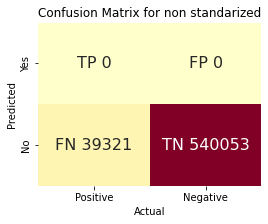

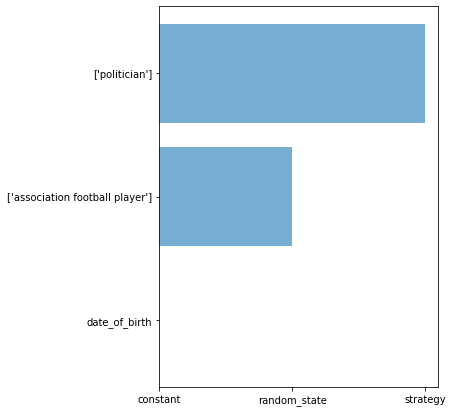

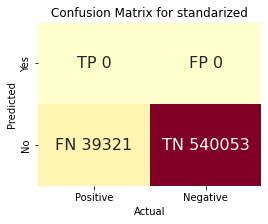

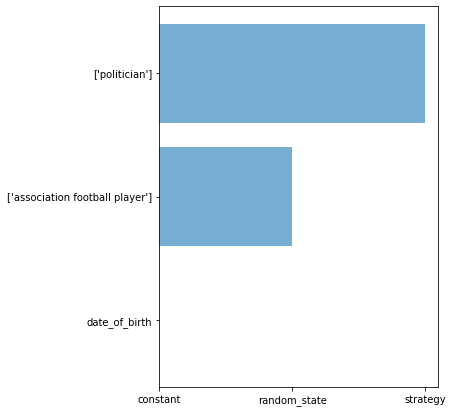

In [83]:
name = ['non standarized', 'standarized']

for idx, data in enumerate(train) : 
    
    dummy_clf = DummyClassifier(strategy="most_frequent") #The classifier always predicts the most frequent class label in the training data.
    dummy_clf.fit(data, train_label) #fit the model
    prediction_proba=dummy_clf.predict_proba(test[idx]) 
    
    confusion_matrix_05_baseline = compute_confusion_matrix(test_label, prediction_proba, 0.5)
    plt.figure(figsize = (4,3)) 
    ax = plot_confusion_matrix(confusion_matrix_05_baseline)
    #setting axis
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    ax.set(title = 'Confusion Matrix for {}'.format(name[idx]))
    
    print('For {}'.format(name[idx]))
    accuracy (confusion_matrix_05_baseline)
    
    features_imp(data.columns, dummy_clf.get_params())
    

### 2 - Logistic Regression

#### 2.1 - standardized vs not

In [ ]:
#A Run Virignie

In [ ]:
pipe = Pipeline([('logistic',LogisticRegression() ) ])



parameters = { 
              'logistic__penalty' : ['l1', 'l2', 'elasticnet'],
              'logistic__C' : [0.01, 0.1, 1, 10, 100, 1000, 10000] ,
              'logistic__solver' : ['liblinear'], 
             }
log = GridSearchCV(pipe, parameters, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
    

for idx, data in enumerate(train): 

    grid_result = log.fit(data, train_label) 
    print('for {} features'.format(name[idx]))
    print('Best Score: ', grid_result.best_score_) 
    print('Best Params: ', grid_result.best_params_)

Fitting 5 folds for each of 21 candidates, totalling 105 fits


In [ ]:
#fin du Run Virginie

*Visualisation of the best selected model :*

In [ ]:
logistic = LogisticRegression(solver='lbfgs', max_iter=10000)
logistic.fit(train_features_std,train_label)
prediction_proba = logistic.predict_proba(test_features_std)

In [ ]:
for idx, data in enumerate(train) : 
    
    log_clf = LogisticRegression(solver='lbfgs', max_iter=10000)
    log_clf.fit(data, train_label) #fit the model
    prediction_proba=log_clf.predict_proba(test[idx]) 
    
    confusion_matrix_05_log = compute_confusion_matrix(test_label, prediction_proba, 0.5)
    plt.figure(figsize = (4,3)) 
    ax = plot_confusion_matrix(confusion_matrix_05_log)
    #setting axis
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    ax.set(title = 'Confusion Matrix for {}'.format(name[idx]))
    
    print('For {}'.format(name[idx]))
    accuracy (confusion_matrix_05_log)
    
    features_imp(data.columns, log_clf.coef_[0])
    

#### 2.2 - Remove features vs not 

### 3 - Random forest 

#### 3.1 - standardized vs not

In [ ]:
#A run Virginie

In [ ]:
pipe = Pipeline([  
                 ('random_forest', RandomForestClassifier()),  
                 ])

parameters = { 
              'random_forest__n_estimators': [50, 100, 200, 500],    
              'random_forest__max_depth': [5, 10],         
              'random_forest__random_state': [42], 
              }

rf = GridSearchCV(pipe, parameters, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)

for idx, data in enumerate(train): 
    grid_result = rf.fit(data, train_label) 
    print('for {} features'.format(name[idx]))
    print('Best Score: ', grid_result.best_score_) 
    print('Best Params: ', grid_result.best_params_) 
    

In [ ]:
#Fin du Run virginie

*Visualisation of the best selected model :*

#### 3.2 - Remove features vs not 

### 4 - Gradient Boosting

#### 4.1 - standardized vs not

In [ ]:
#A Run virignie

In [38]:
pipe = Pipeline([ 
                 ('boosting', GradientBoostingClassifier()),  
                 ])

parameters = {
              'boosting__loss' : ['deviance', 'expo'],
              'boosting__learning_rate' : [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 10],
              'boosting__n_estimators' : list(range(10,101,10)), }
              

boosting = GridSearchCV(pipe, parameters, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)

for idx, data in enumerate(train): 
    grid_result = boosting.fit(data, train_label) 
    print('for {} features'.format(name[idx]))
    print('Best Score: ', grid_result.best_score_) 
    print('Best Params: ', grid_result.best_params_)

Fitting 10 folds for each of 120 candidates, totalling 1200 fits


KeyboardInterrupt: 

In [ ]:
#fin du run Virignie

*Visualisation of the best selected model :*

In [ ]:
print(gradient_booster.feature_importances_)

# plot
pyplot.bar(range(len(gradient_booster.feature_importances_)), gradient_booster.feature_importances_)
pyplot.show()

#### 4.2 - Remove features vs not 

# Temporal Evolution - ANISSA

> Years and month 

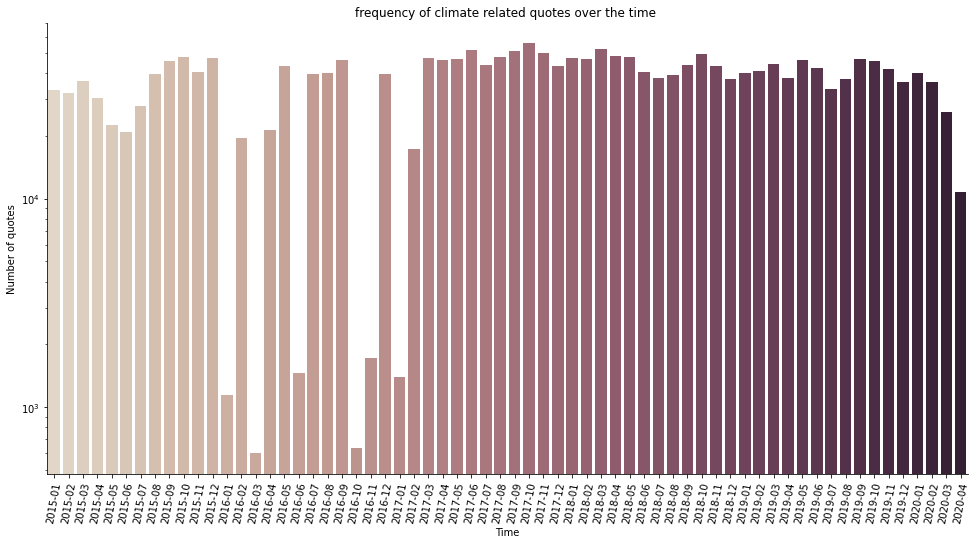

In [5]:
ax=sns.catplot(data=subdata, x = 'date',  kind="count", 
               palette="ch:.25",height=7, aspect=2)
ax.set_xticklabels(rotation=80)

ax.set(xlabel='Time', ylabel='Number of quotes', 
       title= 'frequency of climate related quotes over the time ', yscale='log') #We chose a log scale for better data visulalisation. 

sns.despine()

> Years

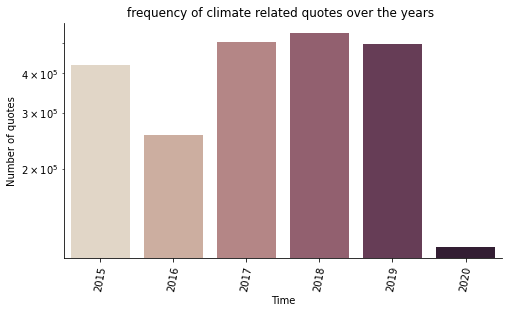

In [6]:
subdata_years = subdata.copy()
subdata_years['date'] = pd.to_datetime(subdata_years['date']).dt.strftime('%Y')


ax=sns.catplot(data=subdata_years, x = 'date',  kind="count", 
               palette="ch:.25",height=4, aspect=1.8)

ax.set_xticklabels(rotation=80)

ax.set(xlabel='Time', ylabel='Number of quotes', 
       title= 'frequency of climate related quotes over the years ', yscale='log') #We chose a log scale for better data visulalisation. 

sns.despine()

# Majority representation - VIRGINIE

In [ ]:
top_10 = subdata.copy()
speaker_time = top_10[['speaker','date','numOccurrences']]
count_top_10 = speaker_time.groupby('speaker')['numOccurrences'].agg(['count']).sort_values('count', ascending=False).head(10)

In [ ]:
count_top_10

In [ ]:
speaker_list = speaker_time['speaker'].tolist()

x = 0 
big_ls = []

for i in count_top_10.index:
    ls = []
    x = x+1
    if i in speaker_list:
        ls.append(speaker_time['date'])
        big_ls.append(ls)

count_top_10['date'] = big_ls
count_top_10

In [ ]:
x_speaker = count_top_10.index.tolist()
y_count = count_top_10['count']

count_top_10.plot.bar()

# Climate speaking proprotion - VIRGINIE

# NLP - 

In [3]:
import warnings; warnings.simplefilter('ignore')
import os, codecs, string, random
from numpy.random import seed as random_seed
from numpy.random import shuffle as random_shuffle 

seed = 42
random.seed(seed)
np.random.seed(seed)

#NLP libraries
import spacy, nltk, gensim, sklearn
import pyLDAvis.gensim_models as gensimvis
#import pyLDAvis.gensim

#Vader
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#Scikit imports
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

In [4]:
analyzer = SentimentIntensityAnalyzer()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
dico={} #We create a dictonary to loop over our years. 
for date in [2020, 2019, 2018, 2017, 2016, 2015]:
    dico[date] = pd.read_csv(f"data/clean_quotes-{date}.bz2", compression = 'bz2')

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
dico_quotes = {}
for date in [2020, 2019, 2018, 2017, 2016, 2015]:
    dico_quotes[date] = dico[date]['quotation']

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
def print_sentiment(text):
    
    vs = analyzer.polarity_scores(text)
    print(text, '\n')
    print('Negative sentiment:',vs['neg'])
    print('Neutral sentiment:',vs['neu'])
    print('Positive sentiment:',vs['pos'])
    print('Compound sentiment:',vs['compound'])
    return vs 

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Distributions

### Positive and negative distributions through the years

In [8]:
positive_sent = {}
negative_sent = {}
ls_pos = []
ls_neg = []

#iterate through the sentencs, get polarity scores, choose a value

for date in [2020,2019]: #, 2019, 2018, 2017, 2016, 2015]:
    for quote in dico_quotes[date]:
        ls_pos.append(analyzer.polarity_scores(quote)['pos'])
        ls_neg.append(analyzer.polarity_scores(quote)['neg'])
    
    positive_sent[date] = ls_pos
    negative_sent[date] = ls_neg

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [47]:
def get_above_zero(my_list):
    np_arr = np.array(my_list)
    return np_arr[np_arr > 0]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


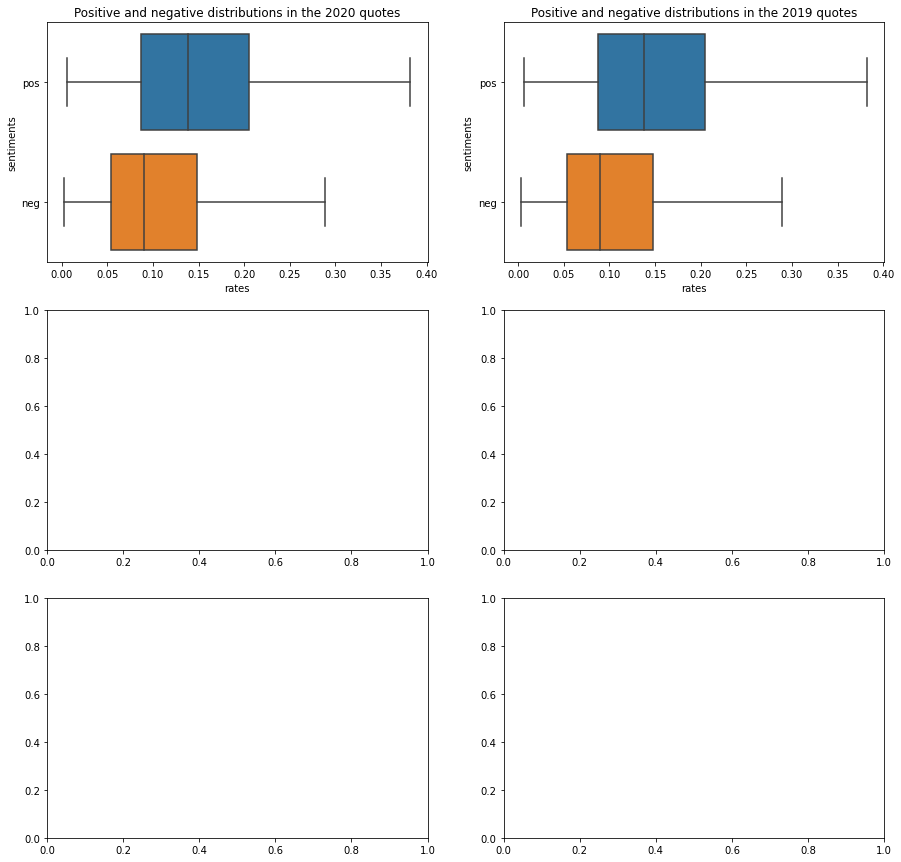

In [100]:
fig, axes = plt.subplots(3,2, figsize=(15,15))




for i, date in enumerate(positive_sent.keys()): #add colors palette and 2015->2020
    to_plot = [get_above_zero(positive_sent[date]),get_above_zero(negative_sent[date])]
    line, col = divmod(i, 2)
    sentiments = 'pos','neg'
    sns.boxplot(data = to_plot, orient = "h", ax = axes[line,col],showfliers=False).set(title = f'Positive and negative distributions in the {date} quotes', xlabel='rates', ylabel='sentiments')
    axes[line,col].set_yticklabels(['pos','neg'])

### Neutral ditribution

In [ ]:
neutral_sent = {}
ls_neu = []


#iterate through the sentencs, get polarity scores, choose a value

for date in [2020,2019]: #, 2019, 2018, 2017, 2016, 2015]:
    for quote in dico_quotes[date]:
        ls_pos.append(analyzer.polarity_scores(quote)['neu'])
    
    neutral_sent[date] = ls_neu